In [116]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [117]:
np.random.rand(2)

array([0.93099945, 0.8775305 ])

# Model

In [118]:
def change_state(x, x1, x2):

    if np.array_equal(x, x1):
        return x2.copy()
    
    elif np.array_equal(x, x2):
        return x1.copy()

def get_valence_signal(x, x1, x2, R1, R2):

    if np.array_equal(x, x1):
        return R1
    elif np.array_equal(x, x2):
        return R2
    
def compute_p_change(y):

    if y<0.05:
        return 0.05
    else:
        return y
    
class BCM:
    
    def __init__(self, block_threshold, tau_w, tau_theta, theta0):

        self.tau_w = tau_w
        self.tau_theta = tau_theta

        self.theta = theta0

        self.block_threshold = block_threshold
    
    def get_weights_update(self, x, y, R):

        theta_dot = - 1./self.tau_theta * (self.theta - y**2)

        w_dot = 1./self.tau_w * -R * x * y * (y - self.theta)

        if not self.block_threshold:
            self.theta = self.theta + theta_dot
        
        return w_dot

# Parameters

In [119]:
# Possible states
x1, x2 = np.array([1., 0.]), np.array([0., 1.])

# Rs
Rm = -1 
Rp = 1.5

# Other parameters
tau_w = 100
tau_theta = 50

# Number of steps
number_of_mice = 50
steps_phase1 = 10000
steps_phase2 = 30000

# Data storage
data = {'sham': {'phase_1': [], 'phase_2': []}, 'aCB1KO': {'phase_1': [], 'phase_2': []}}

# Data Collection

In [120]:
# Sham Mice
for mouse_id in tqdm(range(number_of_mice)):

    sham_mouse = BCM(block_threshold=False, tau_w=tau_w, tau_theta=tau_theta, theta0=0.)

    temp_dict = {'states': [], 'rates': [], 'thetas': [], 'weights': []}

    # phase 1
    R1 = Rp
    R2 = Rm

    x = x1.copy()
    w = np.array([0.05, 0.05])

    for i in range(steps_phase1):

        x_old = x.copy()

        y = np.dot(w, x)

        p_change = compute_p_change(y)

        if np.random.rand()< p_change:
            
            x = change_state(x, x1, x2)
        
        R = get_valence_signal(x, x1, x2, R1, R2)
        w += sham_mouse.get_weights_update(x_old, y, R)

        temp_dict['states'].append(x.copy())
        temp_dict['rates' ].append(y.copy())
        temp_dict['thetas'].append(sham_mouse.theta)
        temp_dict['weights'].append(w.copy())

    data['sham']['phase_1'].append(temp_dict.copy())

    temp_dict = {'states': [], 'rates': [], 'thetas': [], 'weights': []}

    # Phase 2
    R1 = Rm
    R2 = Rp

    for i in range(steps_phase2):

        x_old = x.copy()

        y = np.dot(w, x)

        p_change = compute_p_change(y)

        if np.random.rand()< p_change:
            
            x = change_state(x, x1, x2)
        
        R = get_valence_signal(x, x1, x2, R1, R2)
        w += sham_mouse.get_weights_update(x_old, y, R)

        temp_dict['states'].append(x.copy())
        temp_dict['rates' ].append(y.copy())
        temp_dict['thetas'].append(sham_mouse.theta)
        temp_dict['weights'].append(w.copy())

    data['sham']['phase_2'].append(temp_dict.copy())

100%|██████████| 50/50 [00:12<00:00,  3.98it/s]


In [121]:
# aCB1KO Mice
for mouse_id in tqdm(range(number_of_mice)):

    aCB1KO_mouse = BCM(block_threshold=True, tau_w=tau_w, tau_theta=tau_theta, theta0=0.018)

    # phase 1
    temp_dict = {'states': [], 'rates': [], 'thetas': [], 'weights': []}

    R1 = Rp
    R2 = Rm

    x = x1.copy()
    w = np.array([0.05, 0.05])

    for i in range(steps_phase1):

        x_old = x.copy()

        y = np.dot(w, x)

        p_change = compute_p_change(y)

        if np.random.rand()< p_change:
            
            x = change_state(x, x1, x2)
        
        R = get_valence_signal(x, x1, x2, R1, R2)
        w += aCB1KO_mouse.get_weights_update(x_old, y, R)

        temp_dict['states'].append(x.copy())
        temp_dict['rates' ].append(y.copy())
        temp_dict['thetas'].append(aCB1KO_mouse.theta)
        temp_dict['weights'].append(w.copy())
    
    data['aCB1KO']['phase_1'].append(temp_dict.copy())

    # Phase 2
    temp_dict = {'states': [], 'rates': [], 'thetas': [], 'weights': []}
                    
    R1 = Rm
    R2 = Rp
    
    for i in range(steps_phase2):

        x_old = x.copy()

        y = np.dot(w, x)

        p_change = compute_p_change(y)

        if np.random.rand()< p_change:
            
            x = change_state(x, x1, x2)
        
        R = get_valence_signal(x, x1, x2, R1, R2)
        w += aCB1KO_mouse.get_weights_update(x_old, y, R)

        temp_dict['states'].append(x.copy())
        temp_dict['rates' ].append(y.copy())
        temp_dict['thetas'].append(aCB1KO_mouse.theta)
        temp_dict['weights'].append(w.copy())

    data['aCB1KO']['phase_2'].append(temp_dict.copy())

100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


# Data Visualization

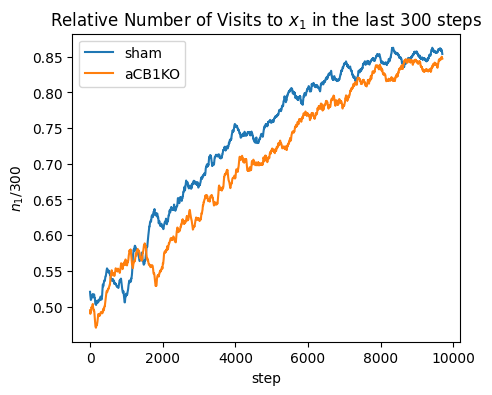

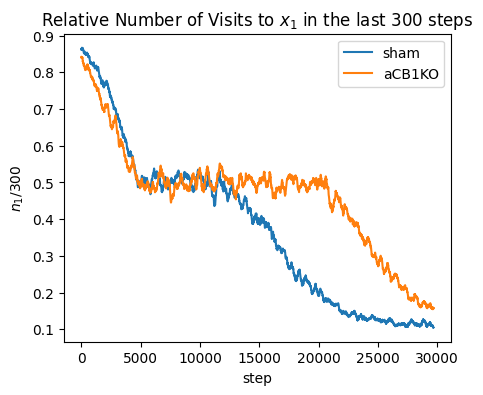

In [122]:
fig, ax = plt.subplots(figsize=(5,4))

window = 300

all_visits_x1_sham = []
all_visits_x1_aCB1KO = []

for agent_id in range(number_of_mice):

    one_hot_vec_x1_sham = np.array([x[0] for x in data['sham']['phase_1'][agent_id]['states']])
    one_hot_vec_x1_aCB1KO = np.array([x[0] for x in data['aCB1KO']['phase_1'][agent_id]['states']])

    visits_x1_sham = []
    visits_x1_aCB1KO = []

    for i in range(steps_phase1-window):
        visits_x1_sham.append(one_hot_vec_x1_sham[i:i+window].mean())
        visits_x1_aCB1KO.append(one_hot_vec_x1_aCB1KO[i:i+window].mean())
    
    all_visits_x1_sham.append(visits_x1_sham)
    all_visits_x1_aCB1KO.append(visits_x1_aCB1KO)

average_visits_x1_sham = np.mean(all_visits_x1_sham, axis=0)
average_visits_x1_aCB1KO = np.mean(all_visits_x1_aCB1KO, axis=0)
    
ax.plot(average_visits_x1_sham, label='sham')
ax.plot(average_visits_x1_aCB1KO, label='aCB1KO')

ax.set_title("Relative Number of Visits to $x_1$ in the last 300 steps")
ax.set_xlabel('step')
ax.set_ylabel('$n_1$/300')
ax.legend()


## Plots of PHASE 2
fig, ax = plt.subplots(figsize=(5,4))

window = 300

all_visits_x1_sham = []
all_visits_x1_aCB1KO = []

for agent_id in range(number_of_mice):

    one_hot_vec_x1_sham = np.array([x[0] for x in data['sham']['phase_2'][agent_id]['states']])
    one_hot_vec_x1_aCB1KO = np.array([x[0] for x in data['aCB1KO']['phase_2'][agent_id]['states']])

    visits_x1_sham = []
    visits_x1_aCB1KO = []

    for i in range(steps_phase2-window):
        visits_x1_sham.append(one_hot_vec_x1_sham[i:i+window].mean())
        visits_x1_aCB1KO.append(one_hot_vec_x1_aCB1KO[i:i+window].mean())
    
    all_visits_x1_sham.append(visits_x1_sham)
    all_visits_x1_aCB1KO.append(visits_x1_aCB1KO)

average_visits_x1_sham = np.mean(all_visits_x1_sham, axis=0)
average_visits_x1_aCB1KO = np.mean(all_visits_x1_aCB1KO, axis=0)
    
ax.plot(average_visits_x1_sham, label='sham')
ax.plot(average_visits_x1_aCB1KO, label='aCB1KO')

ax.set_title("Relative Number of Visits to $x_1$ in the last 300 steps")
ax.set_xlabel('step')
ax.set_ylabel('$n_1$/300')
ax.legend()

plt.show()

(0.0, 0.1)

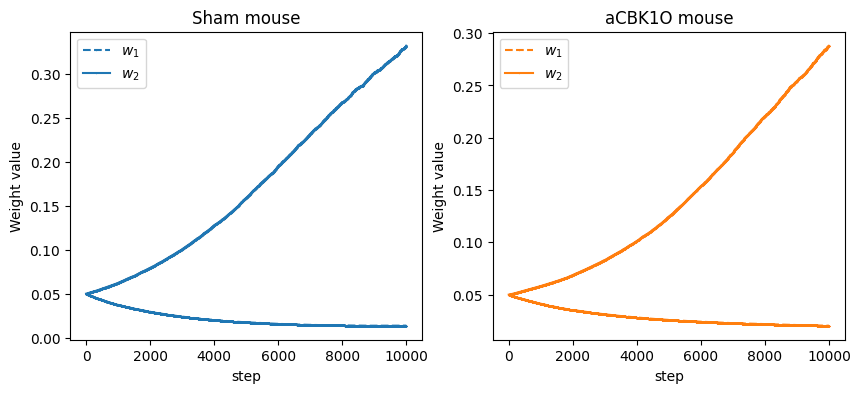

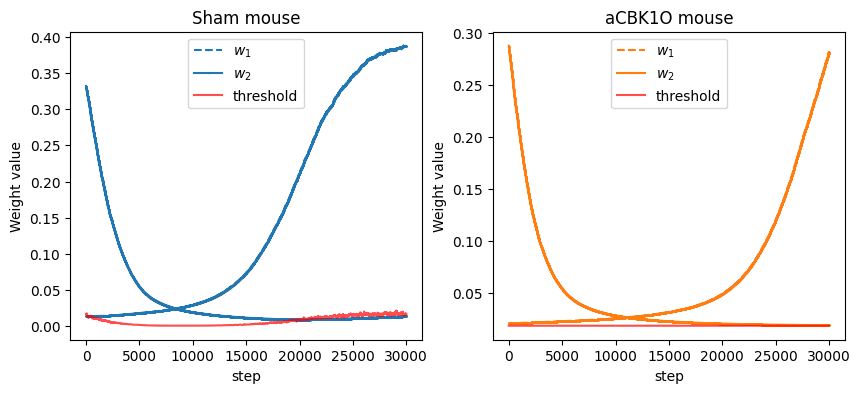

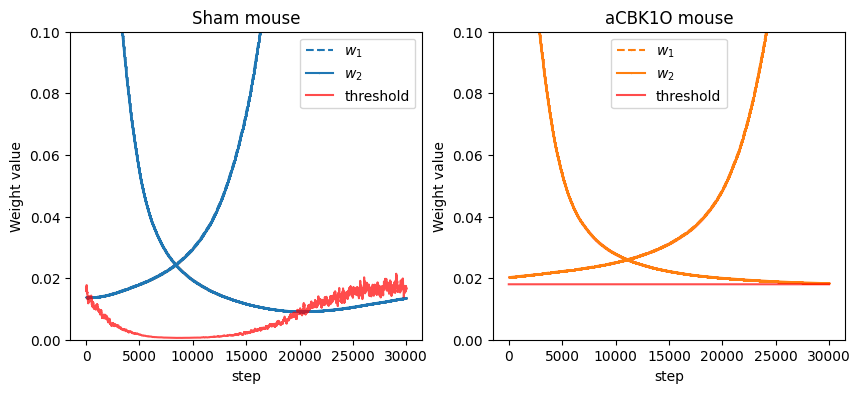

In [123]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

all_weights_sham = []
all_weights_aCB1KO = []

for agent_id in range(number_of_mice):

    all_weights_sham.append(data['sham']['phase_1'][agent_id]['weights'])
    all_weights_aCB1KO.append(data['aCB1KO']['phase_1'][agent_id]['weights'])

average_weights_sham =   np.mean(all_weights_sham, axis=0)
average_weights_aCB1KO = np.mean(all_weights_aCB1KO, axis=0)

ax[0].plot([w[0] for w in average_weights_sham] , label='$w_1$', color='#1f77b4', ls='--', marker='o', ms=0.1)
ax[0].plot([w[1] for w in average_weights_sham] , label='$w_2$', color='#1f77b4', ls='-', marker='o', ms=0.1)

ax[1].plot([w[0] for w in average_weights_aCB1KO] , label='$w_1$', c='#ff7f0e', ls='--', marker='o', ms=0.1)
ax[1].plot([w[1] for w in average_weights_aCB1KO] , label='$w_2$', c='#ff7f0e', ls='-', marker='o', ms=0.1)

ax[0].set_title('Sham mouse')
ax[1].set_title('aCBK1O mouse')
ax[0].set_xlabel('step')
ax[1].set_xlabel('step')
ax[0].set_ylabel('Weight value')
ax[1].set_ylabel('Weight value')

ax[0].legend()
ax[1].legend()

fig, ax = plt.subplots(1,2, figsize=(10,4))

all_weights_sham = []
all_weights_aCB1KO = []

all_theta_sham = []
all_theta_aCB1KO = []

for agent_id in range(number_of_mice):

    all_weights_sham.append(data['sham']['phase_2'][agent_id]['weights'])
    all_theta_sham.append(data['sham']['phase_2'][agent_id]['thetas'])

    all_weights_aCB1KO.append(data['aCB1KO']['phase_2'][agent_id]['weights'])
    all_theta_aCB1KO.append(data['aCB1KO']['phase_2'][agent_id]['thetas'])

average_weights_sham =   np.mean(all_weights_sham, axis=0)
average_weights_aCB1KO = np.mean(all_weights_aCB1KO, axis=0)

average_theta_sham = np.mean(all_theta_sham, axis=0)
average_theta_aCB1KO = np.mean(all_theta_aCB1KO, axis=0)

ax[0].plot([w[0] for w in average_weights_sham] , 
            label='$w_1$', color='#1f77b4', ls='--', marker='o', ms=0.1)
ax[0].plot([w[1] for w in average_weights_sham] , 
            label='$w_2$', color='#1f77b4', ls='-', marker='o', ms=0.1)

ax[1].plot([w[0] for w in average_weights_aCB1KO] , 
            label='$w_1$', c='#ff7f0e', ls='--', marker='o', ms=0.1)
ax[1].plot([w[1] for w in average_weights_aCB1KO] , 
            label='$w_2$', c='#ff7f0e', ls='-', marker='o', ms=0.1)

ax[0].plot(average_theta_sham, color='red', label='threshold', alpha=0.7)
ax[1].plot(average_theta_aCB1KO, color='red', label='threshold', alpha=0.7)

ax[0].set_title('Sham mouse')
ax[1].set_title('aCBK1O mouse')
ax[0].set_xlabel('step')
ax[1].set_xlabel('step')
ax[0].set_ylabel('Weight value')
ax[1].set_ylabel('Weight value')

ax[0].legend()
ax[1].legend()

#########
fig, ax = plt.subplots(1,2, figsize=(10,4))

all_weights_sham = []
all_weights_aCB1KO = []

all_theta_sham = []
all_theta_aCB1KO = []

for agent_id in range(number_of_mice):

    all_weights_sham.append(data['sham']['phase_2'][agent_id]['weights'])
    all_theta_sham.append(data['sham']['phase_2'][agent_id]['thetas'])

    all_weights_aCB1KO.append(data['aCB1KO']['phase_2'][agent_id]['weights'])
    all_theta_aCB1KO.append(data['aCB1KO']['phase_2'][agent_id]['thetas'])

average_weights_sham =   np.mean(all_weights_sham, axis=0)
average_weights_aCB1KO = np.mean(all_weights_aCB1KO, axis=0)

average_theta_sham = np.mean(all_theta_sham, axis=0)
average_theta_aCB1KO = np.mean(all_theta_aCB1KO, axis=0)

ax[0].plot([w[0] for w in average_weights_sham] , 
            label='$w_1$', color='#1f77b4', ls='--', marker='o', ms=0.1)
ax[0].plot([w[1] for w in average_weights_sham] , 
            label='$w_2$', color='#1f77b4', ls='-', marker='o', ms=0.1)

ax[1].plot([w[0] for w in average_weights_aCB1KO] , 
            label='$w_1$', c='#ff7f0e', ls='--', marker='o', ms=0.1)
ax[1].plot([w[1] for w in average_weights_aCB1KO] , 
            label='$w_2$', c='#ff7f0e', ls='-', marker='o', ms=0.1)

ax[0].plot(average_theta_sham, color='red', label='threshold', alpha=0.7)
ax[1].plot(average_theta_aCB1KO, color='red', label='threshold', alpha=0.7)

ax[0].set_title('Sham mouse')
ax[1].set_title('aCBK1O mouse')
ax[0].set_xlabel('step')
ax[1].set_xlabel('step')
ax[0].set_ylabel('Weight value')
ax[1].set_ylabel('Weight value')

ax[0].legend()
ax[1].legend()

ax[0].set_ylim(0, 0.1)
ax[1].set_ylim(0, 0.1)


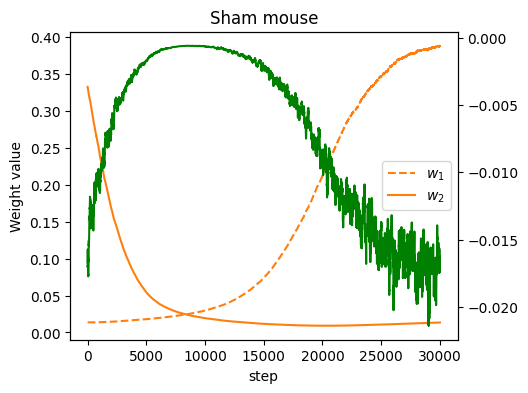

In [124]:
## Zoomed Plot
fig, ax = plt.subplots( figsize=(5,4))

all_weights_sham = []
all_weights_aCB1KO = []

all_theta_sham = []
all_theta_aCB1KO = []

for agent_id in range(number_of_mice):

    all_weights_sham.append(data['sham']['phase_2'][agent_id]['weights'])
    all_theta_sham.append(data['sham']['phase_2'][agent_id]['thetas'])

    all_weights_aCB1KO.append(data['aCB1KO']['phase_2'][agent_id]['weights'])
    all_theta_aCB1KO.append(data['aCB1KO']['phase_2'][agent_id]['thetas'])

average_weights_sham =   np.mean(all_weights_sham, axis=0)
average_weights_aCB1KO = np.mean(all_weights_aCB1KO, axis=0)

average_theta_sham = np.mean(all_theta_sham, axis=0)
average_theta_aCB1KO = np.mean(all_theta_aCB1KO, axis=0)

ax.plot([w[0] for w in average_weights_sham] , label='$w_1$', color='#ff7f0e', linestyle='--')
ax.plot([w[1] for w in average_weights_sham] , label='$w_2$', color='#ff7f0e')

ax_twin = ax.twinx()
ax_twin.plot(-average_theta_sham, color='green', label='threshold')


ax.set_title('Sham mouse')
ax.set_xlabel('step')
ax.set_ylabel('Weight value')

ax.legend()


plt.show()